In [1]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [2]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [4]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 460, Edges: 4020

 Node types:
  default: [460]
    Features: float32 vector, length 650
    Edge types: default-default->default

 Edge types:
    default-default->default: [4020]
        Weights: range=[0.700023, 0.979342], mean=0.782582, std=0.0775818
        Features: none


In [5]:
# Splitting data into train/validation/test

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

series_classes = df_classes['class']
series_classes = series_classes.sample(frac=1)

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  321
Len validation:  69
Len test:  70

Len everything:  460


In [6]:
from collections import Counter
counter = Counter(train_subjects)
counter

Counter({'stage2': 26,
         'stage1': 153,
         'control': 50,
         'stage3': 54,
         'stage4': 38})

In [10]:
target_encoding.inverse_transform(np.array([[1,0,0,0,0], 
                                            [0,1,0,0,0],
                                            [0,0,1,0,0],
                                            [0,0,0,1,0],
                                            [0,0,0,0,1]]))

array(['control', 'stage1', 'stage2', 'stage3', 'stage4'], dtype='<U7')

In [8]:
# weights logic taken from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
num_samples = 0
for cls in counter:
    num_samples += counter[cls]
num_classes = len(counter)

w_control = num_samples / (num_classes * counter['control'])
w_s1 = num_samples / (num_classes * counter['stage1'])
w_s2 = num_samples / (num_classes * counter['stage2'])
w_s3 = num_samples / (num_classes * counter['stage3'])
w_s4 = num_samples / (num_classes * counter['stage4'])

weights = np.array([w_control, w_s1, w_s2, w_s3, w_s4])
weights

array([1.284     , 0.41960784, 2.46923077, 1.18888889, 1.68947368])

## The cell below is used to downsample the training data. Skip it if this is not the goal

In [123]:
# Testar downsample na train_subjects
train_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(
            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(
            train_subjects.loc[train_subjects == 'control'][0:50])

train_subjects=train_subjects_downsample
Counter(train_subjects_downsample)

Counter({'stage1': 50,
         'stage2': 37,
         'stage3': 50,
         'stage4': 50,
         'control': 50})

In [11]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [12]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [23]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

nb_classes = 5
input_dim = df_features.loc[train_subjects.index].values.shape[1]

model = Sequential()
model.add(Dense(128, input_dim=input_dim))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=["acc"])

X_train = df_features.loc[train_subjects.index].values
y_train = train_targets

X_val = df_features.loc[val_subjects.index].values
y_val = val_targets

print("Training...")
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), batch_size=8, verbose=2)

Training...
Epoch 1/500
41/41 - 1s - loss: 4.2467 - acc: 0.4174 - val_loss: 3.0228 - val_acc: 0.2464
Epoch 2/500
41/41 - 0s - loss: 1.9247 - acc: 0.4673 - val_loss: 1.9729 - val_acc: 0.6232
Epoch 3/500
41/41 - 0s - loss: 1.4727 - acc: 0.5296 - val_loss: 1.9366 - val_acc: 0.2899
Epoch 4/500
41/41 - 0s - loss: 1.2991 - acc: 0.5701 - val_loss: 2.1051 - val_acc: 0.3478
Epoch 5/500
41/41 - 0s - loss: 1.2486 - acc: 0.5296 - val_loss: 1.1998 - val_acc: 0.6522
Epoch 6/500
41/41 - 0s - loss: 1.2923 - acc: 0.5857 - val_loss: 1.2867 - val_acc: 0.5217
Epoch 7/500
41/41 - 0s - loss: 1.2626 - acc: 0.5794 - val_loss: 1.2707 - val_acc: 0.3913
Epoch 8/500
41/41 - 0s - loss: 1.1062 - acc: 0.6199 - val_loss: 1.9047 - val_acc: 0.3333
Epoch 9/500
41/41 - 0s - loss: 1.0858 - acc: 0.5950 - val_loss: 2.0964 - val_acc: 0.2609
Epoch 10/500
41/41 - 0s - loss: 1.0540 - acc: 0.6293 - val_loss: 1.0309 - val_acc: 0.6667
Epoch 11/500
41/41 - 0s - loss: 1.0460 - acc: 0.6449 - val_loss: 1.0873 - val_acc: 0.6232
Epoch 1

Epoch 92/500
41/41 - 0s - loss: 0.3724 - acc: 0.9408 - val_loss: 3.1910 - val_acc: 0.6957
Epoch 93/500
41/41 - 0s - loss: 0.0716 - acc: 0.9813 - val_loss: 3.5522 - val_acc: 0.6667
Epoch 94/500
41/41 - 0s - loss: 0.2068 - acc: 0.9533 - val_loss: 3.0871 - val_acc: 0.6812
Epoch 95/500
41/41 - 0s - loss: 0.1689 - acc: 0.9626 - val_loss: 3.0793 - val_acc: 0.6232
Epoch 96/500
41/41 - 0s - loss: 0.0293 - acc: 0.9907 - val_loss: 4.8920 - val_acc: 0.5942
Epoch 97/500
41/41 - 0s - loss: 0.1712 - acc: 0.9657 - val_loss: 2.8232 - val_acc: 0.6957
Epoch 98/500
41/41 - 0s - loss: 0.0583 - acc: 0.9720 - val_loss: 2.8857 - val_acc: 0.6957
Epoch 99/500
41/41 - 0s - loss: 0.1210 - acc: 0.9564 - val_loss: 3.7273 - val_acc: 0.6522
Epoch 100/500
41/41 - 0s - loss: 0.1119 - acc: 0.9751 - val_loss: 2.8338 - val_acc: 0.6812
Epoch 101/500
41/41 - 0s - loss: 0.1101 - acc: 0.9751 - val_loss: 2.6551 - val_acc: 0.6667
Epoch 102/500
41/41 - 0s - loss: 0.2373 - acc: 0.9595 - val_loss: 3.4860 - val_acc: 0.5942
Epoch 1

Epoch 183/500
41/41 - 0s - loss: 0.0420 - acc: 0.9875 - val_loss: 4.6700 - val_acc: 0.6667
Epoch 184/500
41/41 - 0s - loss: 0.0819 - acc: 0.9782 - val_loss: 7.5028 - val_acc: 0.6667
Epoch 185/500
41/41 - 0s - loss: 0.0969 - acc: 0.9875 - val_loss: 4.5989 - val_acc: 0.7101
Epoch 186/500
41/41 - 0s - loss: 0.1235 - acc: 0.9751 - val_loss: 4.0371 - val_acc: 0.6522
Epoch 187/500
41/41 - 0s - loss: 0.1601 - acc: 0.9844 - val_loss: 4.6229 - val_acc: 0.7101
Epoch 188/500
41/41 - 0s - loss: 0.0306 - acc: 0.9907 - val_loss: 5.2082 - val_acc: 0.6667
Epoch 189/500
41/41 - 0s - loss: 0.1139 - acc: 0.9844 - val_loss: 4.7394 - val_acc: 0.6377
Epoch 190/500
41/41 - 0s - loss: 0.0767 - acc: 0.9844 - val_loss: 4.6980 - val_acc: 0.6522
Epoch 191/500
41/41 - 0s - loss: 0.0357 - acc: 0.9844 - val_loss: 6.9870 - val_acc: 0.6957
Epoch 192/500
41/41 - 0s - loss: 0.1846 - acc: 0.9813 - val_loss: 4.3626 - val_acc: 0.6667
Epoch 193/500
41/41 - 0s - loss: 0.1187 - acc: 0.9688 - val_loss: 5.9525 - val_acc: 0.5942

Epoch 273/500
41/41 - 0s - loss: 0.0744 - acc: 0.9844 - val_loss: 6.4219 - val_acc: 0.6522
Epoch 274/500
41/41 - 0s - loss: 0.2393 - acc: 0.9844 - val_loss: 5.2646 - val_acc: 0.6087
Epoch 275/500
41/41 - 0s - loss: 0.0365 - acc: 0.9907 - val_loss: 5.1538 - val_acc: 0.6522
Epoch 276/500
41/41 - 0s - loss: 0.0656 - acc: 0.9782 - val_loss: 8.3661 - val_acc: 0.6522
Epoch 277/500
41/41 - 0s - loss: 0.1121 - acc: 0.9844 - val_loss: 4.9914 - val_acc: 0.5942
Epoch 278/500
41/41 - 0s - loss: 0.0561 - acc: 0.9875 - val_loss: 5.3308 - val_acc: 0.6522
Epoch 279/500
41/41 - 0s - loss: 0.2025 - acc: 0.9813 - val_loss: 5.0323 - val_acc: 0.6957
Epoch 280/500
41/41 - 0s - loss: 0.0852 - acc: 0.9938 - val_loss: 9.0966 - val_acc: 0.6522
Epoch 281/500
41/41 - 0s - loss: 0.0332 - acc: 0.9907 - val_loss: 7.7712 - val_acc: 0.5942
Epoch 282/500
41/41 - 0s - loss: 0.1861 - acc: 0.9751 - val_loss: 5.9535 - val_acc: 0.6957
Epoch 283/500
41/41 - 0s - loss: 2.2000e-04 - acc: 1.0000 - val_loss: 6.3831 - val_acc: 0.

Epoch 363/500
41/41 - 0s - loss: 3.1779e-05 - acc: 1.0000 - val_loss: 5.7891 - val_acc: 0.6667
Epoch 364/500
41/41 - 0s - loss: 6.4712e-06 - acc: 1.0000 - val_loss: 6.9824 - val_acc: 0.6812
Epoch 365/500
41/41 - 0s - loss: 0.1002 - acc: 0.9844 - val_loss: 5.0995 - val_acc: 0.6232
Epoch 366/500
41/41 - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 5.6428 - val_acc: 0.6957
Epoch 367/500
41/41 - 0s - loss: 0.0688 - acc: 0.9875 - val_loss: 6.2773 - val_acc: 0.6812
Epoch 368/500
41/41 - 0s - loss: 0.0082 - acc: 0.9969 - val_loss: 6.5848 - val_acc: 0.6522
Epoch 369/500
41/41 - 0s - loss: 0.0568 - acc: 0.9907 - val_loss: 6.5852 - val_acc: 0.7101
Epoch 370/500
41/41 - 0s - loss: 3.5575e-04 - acc: 1.0000 - val_loss: 6.1284 - val_acc: 0.6522
Epoch 371/500
41/41 - 0s - loss: 0.1992 - acc: 0.9720 - val_loss: 6.3846 - val_acc: 0.6812
Epoch 372/500
41/41 - 0s - loss: 0.0119 - acc: 0.9938 - val_loss: 7.4763 - val_acc: 0.6812
Epoch 373/500
41/41 - 0s - loss: 0.0093 - acc: 0.9969 - val_loss: 8.9955 - val

Epoch 453/500
41/41 - 0s - loss: 0.0137 - acc: 0.9969 - val_loss: 6.8407 - val_acc: 0.6522
Epoch 454/500
41/41 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 7.0851 - val_acc: 0.6377
Epoch 455/500
41/41 - 0s - loss: 0.0386 - acc: 0.9938 - val_loss: 6.8417 - val_acc: 0.6377
Epoch 456/500
41/41 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 7.7321 - val_acc: 0.6232
Epoch 457/500
41/41 - 0s - loss: 0.0960 - acc: 0.9844 - val_loss: 8.4842 - val_acc: 0.5942
Epoch 458/500
41/41 - 0s - loss: 0.0115 - acc: 0.9969 - val_loss: 8.6352 - val_acc: 0.6812
Epoch 459/500
41/41 - 0s - loss: 0.0670 - acc: 0.9907 - val_loss: 6.8727 - val_acc: 0.6377
Epoch 460/500
41/41 - 0s - loss: 0.0095 - acc: 0.9969 - val_loss: 7.5836 - val_acc: 0.6667
Epoch 461/500
41/41 - 0s - loss: 0.0228 - acc: 0.9907 - val_loss: 8.9404 - val_acc: 0.6667
Epoch 462/500
41/41 - 0s - loss: 0.0415 - acc: 0.9875 - val_loss: 7.1087 - val_acc: 0.6232
Epoch 463/500
41/41 - 0s - loss: 0.0762 - acc: 0.9907 - val_loss: 5.1267 - val_acc: 0.6957

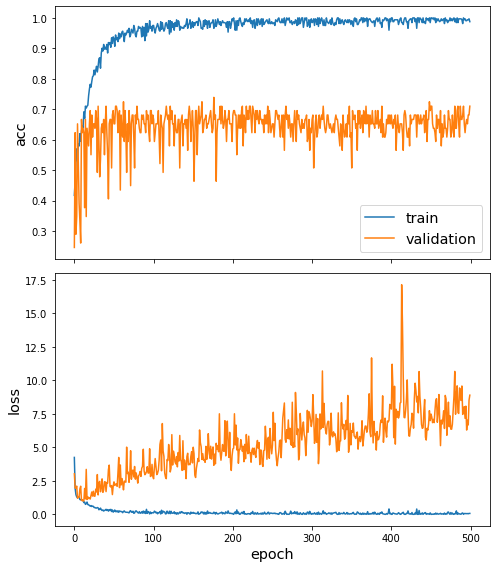

In [24]:
sg.utils.plot_history(history)

In [14]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from __future__ import print_function
from tensorflow import cast, int64, float32
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_true = cast(y_true, dtype=float32)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [25]:
gat = GAT(
    layer_sizes=[100, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.1,
    attn_dropout=0.1,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [26]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.0001),
    loss=losses.categorical_crossentropy,
    #loss=weighted_categorical_crossentropy(weights),#weights/(max(weights)+1)),#np.array([1,1,1,1,1])),#weights),
    metrics=["acc"],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [28]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 2s - loss: 10.0158 - acc: 0.1184 - val_loss: 7.5815 - val_acc: 0.1739
Epoch 2/500
1/1 - 0s - loss: 7.1923 - acc: 0.2025 - val_loss: 5.2995 - val_acc: 0.4493
Epoch 3/500
1/1 - 0s - loss: 6.4071 - acc: 0.3084 - val_loss: 4.6910 - val_acc: 0.5217
Epoch 4/500
1/1 - 0s - loss: 5.7008 - acc: 0.3894 - val_loss: 4.6511 - val_acc: 0.5797
Epoch 5/500
1/1 - 0s - loss: 5.0271 - acc: 0.4237 - val_loss: 4.7983 - val_acc: 0.5797
Epoch 6/500
1/1 - 0s - loss: 5.0579 - acc: 0.5047 - val_loss: 4.6947 - val_acc: 0.5797
Epoch 7/500
1/1 - 0s - loss: 4.1768 - acc: 0.6012 - val_loss: 4.3469 - val_acc: 0.6087
Epoch 8/500
1/1 - 0s - loss: 5.6376 - acc: 0.4517 - val_loss: 3.9318 - val_acc: 0.6087
Epoch 9/500
1/1 - 0s - loss: 4.6689 - acc: 0.5389 - val_loss: 3.5871 - val_acc: 0.5797
Epoch 10/500
1/1 - 0s - loss: 4.3329 - acc: 0.5607 - val_loss: 3.4293 - val_acc: 0.5942
Epoch 11/500
1/1 - 0s - loss: 3.5961 - acc: 0.5857 - val_loss: 3.5699 - val_acc: 0.6232
Epoch 12/500
1/1 - 0s - loss: 3.9777 - a

Epoch 95/500
1/1 - 0s - loss: 1.7272 - acc: 0.6106 - val_loss: 2.0170 - val_acc: 0.4348
Epoch 96/500
1/1 - 0s - loss: 1.9785 - acc: 0.5763 - val_loss: 2.1810 - val_acc: 0.4203
Epoch 97/500
1/1 - 0s - loss: 1.9106 - acc: 0.5389 - val_loss: 2.1041 - val_acc: 0.4348
Epoch 98/500
1/1 - 0s - loss: 1.9991 - acc: 0.5109 - val_loss: 1.8419 - val_acc: 0.4348
Epoch 99/500
1/1 - 0s - loss: 2.1961 - acc: 0.5327 - val_loss: 1.7092 - val_acc: 0.5797
Epoch 100/500
1/1 - 0s - loss: 1.9732 - acc: 0.5919 - val_loss: 1.7285 - val_acc: 0.5942
Epoch 101/500
1/1 - 0s - loss: 2.0000 - acc: 0.6262 - val_loss: 1.7751 - val_acc: 0.6087
Epoch 102/500
1/1 - 0s - loss: 1.8663 - acc: 0.6199 - val_loss: 1.7761 - val_acc: 0.5942
Epoch 103/500
1/1 - 0s - loss: 2.0373 - acc: 0.6199 - val_loss: 1.7232 - val_acc: 0.5942
Epoch 104/500
1/1 - 0s - loss: 1.9001 - acc: 0.6199 - val_loss: 1.7201 - val_acc: 0.5652
Epoch 105/500
1/1 - 0s - loss: 2.0601 - acc: 0.5763 - val_loss: 1.7985 - val_acc: 0.4493
Epoch 106/500
1/1 - 0s - l

1/1 - 0s - loss: 1.3595 - acc: 0.6137 - val_loss: 1.4002 - val_acc: 0.5362
Epoch 188/500
1/1 - 0s - loss: 1.6448 - acc: 0.5358 - val_loss: 1.4104 - val_acc: 0.6232
Epoch 189/500
1/1 - 0s - loss: 1.6880 - acc: 0.6075 - val_loss: 1.4539 - val_acc: 0.6812
Epoch 190/500
1/1 - 0s - loss: 1.6191 - acc: 0.6386 - val_loss: 1.4709 - val_acc: 0.6377
Epoch 191/500
1/1 - 0s - loss: 1.7225 - acc: 0.6480 - val_loss: 1.4390 - val_acc: 0.6522
Epoch 192/500
1/1 - 0s - loss: 1.6132 - acc: 0.6262 - val_loss: 1.3973 - val_acc: 0.6232
Epoch 193/500
1/1 - 0s - loss: 1.7070 - acc: 0.6293 - val_loss: 1.4493 - val_acc: 0.6087
Epoch 194/500
1/1 - 0s - loss: 1.4177 - acc: 0.6012 - val_loss: 1.6712 - val_acc: 0.4638
Epoch 195/500
1/1 - 0s - loss: 1.6366 - acc: 0.5296 - val_loss: 1.7751 - val_acc: 0.4783
Epoch 196/500
1/1 - 0s - loss: 1.4424 - acc: 0.5763 - val_loss: 1.6813 - val_acc: 0.4783
Epoch 197/500
1/1 - 0s - loss: 1.5331 - acc: 0.5950 - val_loss: 1.5933 - val_acc: 0.4493
Epoch 198/500
1/1 - 0s - loss: 1.53

Epoch 280/500
1/1 - 0s - loss: 1.3464 - acc: 0.6417 - val_loss: 1.3690 - val_acc: 0.5652
Epoch 281/500
1/1 - 0s - loss: 1.3791 - acc: 0.5919 - val_loss: 1.3918 - val_acc: 0.5217
Epoch 282/500
1/1 - 0s - loss: 1.2752 - acc: 0.5358 - val_loss: 1.2861 - val_acc: 0.5507
Epoch 283/500
1/1 - 0s - loss: 1.2381 - acc: 0.6542 - val_loss: 1.2021 - val_acc: 0.6232
Epoch 284/500
1/1 - 0s - loss: 1.2028 - acc: 0.6511 - val_loss: 1.1804 - val_acc: 0.6522
Epoch 285/500
1/1 - 0s - loss: 1.2054 - acc: 0.6542 - val_loss: 1.1977 - val_acc: 0.6667
Epoch 286/500
1/1 - 0s - loss: 1.3850 - acc: 0.6199 - val_loss: 1.2361 - val_acc: 0.6812
Epoch 287/500
1/1 - 0s - loss: 1.2840 - acc: 0.6667 - val_loss: 1.2443 - val_acc: 0.6812
Epoch 288/500
1/1 - 0s - loss: 1.2559 - acc: 0.7040 - val_loss: 1.2042 - val_acc: 0.6667
Epoch 289/500
1/1 - 0s - loss: 1.3438 - acc: 0.6885 - val_loss: 1.1656 - val_acc: 0.6667
Epoch 290/500
1/1 - 0s - loss: 1.2524 - acc: 0.6698 - val_loss: 1.1849 - val_acc: 0.5652
Epoch 291/500
1/1 - 0

1/1 - 0s - loss: 0.9555 - acc: 0.7040 - val_loss: 1.1812 - val_acc: 0.6087
Epoch 373/500
1/1 - 0s - loss: 1.0235 - acc: 0.6885 - val_loss: 1.2200 - val_acc: 0.5072
Epoch 374/500
1/1 - 0s - loss: 1.1446 - acc: 0.6231 - val_loss: 1.2846 - val_acc: 0.4928
Epoch 375/500
1/1 - 0s - loss: 1.4552 - acc: 0.4829 - val_loss: 1.2278 - val_acc: 0.4783
Epoch 376/500
1/1 - 0s - loss: 1.1555 - acc: 0.5950 - val_loss: 1.1420 - val_acc: 0.5797
Epoch 377/500
1/1 - 0s - loss: 1.0846 - acc: 0.6885 - val_loss: 1.1230 - val_acc: 0.6232
Epoch 378/500
1/1 - 0s - loss: 1.0826 - acc: 0.6667 - val_loss: 1.1292 - val_acc: 0.6232
Epoch 379/500
1/1 - 0s - loss: 1.0142 - acc: 0.6791 - val_loss: 1.1346 - val_acc: 0.6377
Epoch 380/500
1/1 - 0s - loss: 1.0149 - acc: 0.6417 - val_loss: 1.1338 - val_acc: 0.6232
Epoch 381/500
1/1 - 0s - loss: 0.9230 - acc: 0.7103 - val_loss: 1.1422 - val_acc: 0.5942
Epoch 382/500
1/1 - 0s - loss: 1.0058 - acc: 0.6791 - val_loss: 1.1664 - val_acc: 0.5797
Epoch 383/500
1/1 - 0s - loss: 1.03

Epoch 465/500
1/1 - 0s - loss: 0.9297 - acc: 0.6947 - val_loss: 1.1743 - val_acc: 0.6522
Epoch 466/500
1/1 - 0s - loss: 1.0249 - acc: 0.7009 - val_loss: 1.1925 - val_acc: 0.6522
Epoch 467/500
1/1 - 0s - loss: 1.0113 - acc: 0.6449 - val_loss: 1.2019 - val_acc: 0.6522
Epoch 468/500
1/1 - 0s - loss: 1.0259 - acc: 0.6854 - val_loss: 1.2021 - val_acc: 0.6522
Epoch 469/500
1/1 - 0s - loss: 0.9734 - acc: 0.7103 - val_loss: 1.2029 - val_acc: 0.6232
Epoch 470/500
1/1 - 0s - loss: 0.8954 - acc: 0.7040 - val_loss: 1.2122 - val_acc: 0.5652
Epoch 471/500
1/1 - 0s - loss: 0.8880 - acc: 0.6480 - val_loss: 1.2436 - val_acc: 0.4928
Epoch 472/500
1/1 - 0s - loss: 0.8998 - acc: 0.6885 - val_loss: 1.2545 - val_acc: 0.5072
Epoch 473/500
1/1 - 0s - loss: 1.0159 - acc: 0.6760 - val_loss: 1.2600 - val_acc: 0.5072
Epoch 474/500
1/1 - 0s - loss: 0.9448 - acc: 0.6573 - val_loss: 1.2565 - val_acc: 0.5507
Epoch 475/500
1/1 - 0s - loss: 0.8901 - acc: 0.7072 - val_loss: 1.2645 - val_acc: 0.5942
Epoch 476/500
1/1 - 0

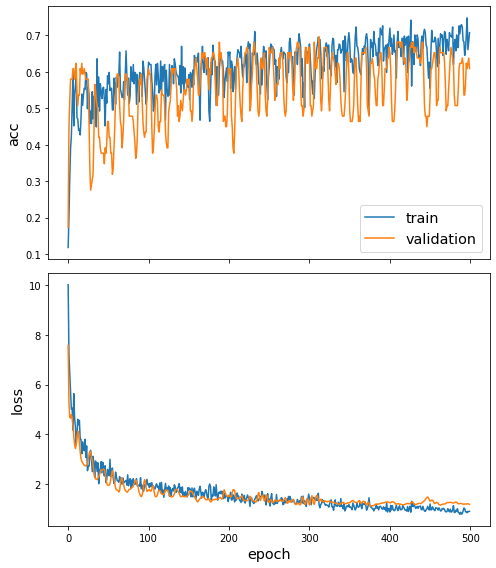

In [36]:
sg.utils.plot_history(history)

In [37]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 38ms/step - loss: 1.7663 - acc: 0.6286

Test Set Metrics:
	loss: 1.7663
	acc: 0.6286


In [38]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [39]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})
df['Predicted'].value_counts()

stage1     277
stage4      78
control     73
stage3      28
stage2       4
Name: Predicted, dtype: int64

In [40]:
G.check_graph_for_ml()

In [41]:
for component in G.connected_components():
    print(len(component))

430
15
6
3
2
2
2


In [42]:
G.node_degrees()

defaultdict(int,
            {'TCGA.CJ.5672.11': 71,
             'TCGA.CJ.5678.11': 54,
             'TCGA.B0.5712.11': 45,
             'TCGA.CZ.5458.11': 32,
             'TCGA.CW.5580.11': 70,
             'TCGA.CZ.5463.11': 70,
             'TCGA.CZ.5469.11': 31,
             'TCGA.CZ.4864.11': 51,
             'TCGA.B8.5549.11': 32,
             'TCGA.B0.5701.11': 69,
             'TCGA.CW.5581.11': 52,
             'TCGA.CZ.5455.11': 30,
             'TCGA.B0.5709.11': 52,
             'TCGA.CZ.5470.11': 39,
             'TCGA.CJ.5676.11': 53,
             'TCGA.CZ.5468.11': 44,
             'TCGA.CZ.5982.11': 48,
             'TCGA.CZ.5461.11': 69,
             'TCGA.CZ.5989.11': 35,
             'TCGA.CJ.6030.11': 53,
             'TCGA.CZ.5456.11': 29,
             'TCGA.CJ.5680.11': 51,
             'TCGA.B8.4622.11': 51,
             'TCGA.CW.6087.11': 66,
             'TCGA.B0.5694.11': 57,
             'TCGA.CZ.5466.11': 53,
             'TCGA.CJ.5679.11': 60,
           

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

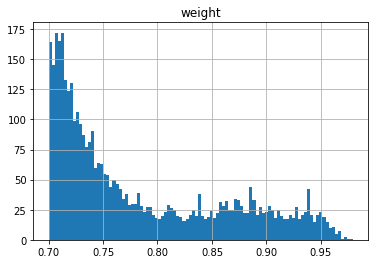

In [46]:
df_patients.hist(column='weight', bins=100)